In [1]:
import pandas as pd
import numpy as np
np.random.seed(0) 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras import backend as K

from tensorflow.keras.optimizers import Adam

from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split

import glob
import os
import cv2
from tqdm import tqdm


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### import data

In [2]:
df= pd.read_csv("test/output/output0.csv")
df.head()

,Amplitudes,Frequencies,Daping coeffitients,Speeds,SNR
0,1.894824,229.127372,2.065563,3.139201,95.113244


In [3]:
df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "test/output/output*.csv"))))

In [4]:
df

,Amplitudes,Frequencies,Daping coeffitients,Speeds,SNR
0,3.670712,213.277862,6.224857,-2.721940,14.291014
0,1.879941,163.226894,0.723691,7.404927,39.169301
0,3.948317,114.884776,6.203916,-2.328775,55.045094
0,2.680349,83.384335,1.240437,-5.460384,60.832520
0,2.375230,69.323893,5.489942,6.107269,61.373392
...,...,...,...,...,...
0,4.403836,18.868849,1.515863,-2.661488,54.076477
0,4.804255,35.105291,9.873786,-3.589260,72.599596
0,4.715750,91.366737,6.698049,-2.129933,73.884334
0,4.778039,137.075316,4.295846,1.079967,27.511666


In [6]:
labels=df.iloc[:,:-1]
labels

,Amplitudes,Frequencies,Daping coeffitients,Speeds
0,3.670712,213.277862,6.224857,-2.721940
0,1.879941,163.226894,0.723691,7.404927
0,3.948317,114.884776,6.203916,-2.328775
0,2.680349,83.384335,1.240437,-5.460384
0,2.375230,69.323893,5.489942,6.107269
...,...,...,...,...
0,4.403836,18.868849,1.515863,-2.661488
0,4.804255,35.105291,9.873786,-3.589260
0,4.715750,91.366737,6.698049,-2.129933
0,4.778039,137.075316,4.295846,1.079967


In [7]:
labels['image_name']=[f"input{x}" for x in range(0,len(labels))]
labels

,Amplitudes,Frequencies,Daping coeffitients,Speeds,image_name
0,3.670712,213.277862,6.224857,-2.721940,input0
0,1.879941,163.226894,0.723691,7.404927,input1
0,3.948317,114.884776,6.203916,-2.328775,input2
0,2.680349,83.384335,1.240437,-5.460384,input3
0,2.375230,69.323893,5.489942,6.107269,input4
...,...,...,...,...,...
0,4.403836,18.868849,1.515863,-2.661488,input95
0,4.804255,35.105291,9.873786,-3.589260,input96
0,4.715750,91.366737,6.698049,-2.129933,input97
0,4.778039,137.075316,4.295846,1.079967,input98


In [8]:
labels.describe()

,Amplitudes,Frequencies,Daping coeffitients,Speeds
count,100.000000,100.000000,100.000000,100.000000
mean,2.491123,123.824120,4.891195,-0.320947
std,1.516537,68.432395,2.607755,4.776358
min,0.152405,17.777114,0.481182,-7.851334
25%,1.035943,62.571286,2.580401,-3.813275
50%,2.630638,120.850451,5.214697,-1.191793
75%,3.876328,183.038364,6.886415,3.592089
max,4.895953,236.906330,9.873786,7.976486


array([[<AxesSubplot:title={'center':'Amplitudes'}>,
        <AxesSubplot:title={'center':'Frequencies'}>],
       [<AxesSubplot:title={'center':'Daping coeffitients'}>,
        <AxesSubplot:title={'center':'Speeds'}>]], dtype=object)

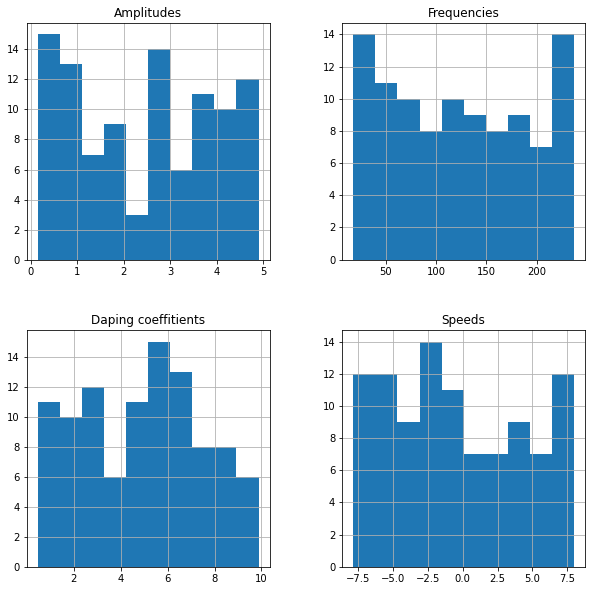

In [9]:
labels.hist(figsize=(10,10))

### Generate data

In [10]:
!git clone https://github.com/DahanDaniel/Algorithm_of_peak_picking.git

fatal: docelowa ścieżka „Algorithm_of_peak_picking” już istnieje i nie jest pustym katalogiem.


In [11]:
import sys
sys.path.insert(0, 'Algorithm_of_peak_picking')

In [12]:
%cd Algorithm_of_peak_picking/
!git pull
%cd ..

/home/anna_s/Ania/UW/projekty/NMR/predict_data/Algorithm_of_peak_picking
Już aktualne.
/home/anna_s/Ania/UW/projekty/NMR/predict_data


In [13]:
import copy
from sys import exit
import os

import numpy as np
# from google.colab import files

from Algorithm_of_peak_picking.RadonClass import *

In [50]:
ITERATIONS = 100

NO_SERIES  = 20
RESOLUTION = 2**8 # number of points describing spectra

DWMIN, DWMAX, DDW = -10, 10, .01 # Domain of rates of change

MAX_NO_PEAKS = 2

In [51]:
def create_random_data(max_no_peaks):
    # Draw a random number of peaks between 1 and max_no_peaks.
    N = np.random.randint(1, max_no_peaks+1)

    # Randomize peaks' parameters.
    amplitudes = np.random.uniform(.1, 5, N)
    frequencies = np.random.uniform(10, RESOLUTION - 10, N)
    damping_coeffs = np.random.uniform(0.1, 10, N)
    speeds = np.random.uniform(-8, 8, N)

    # Draw signal-to-noise ratio; set to 0 if no noise should be added.
    snr = np.random.uniform(10, 100) # 0 # 

    params = Params(amplitudes,
                    frequencies,
                    damping_coeffs,
                    speeds,
                    NO_SERIES,
                    RESOLUTION,
                    snr)
    
    radon_instance = Radon(params, DWMIN, DWMAX, DDW, 'Params')

    # Create input dataframe containing radon spectra of the input parameters.
    # Columns represent the frequency dimention,
    # rows represent the Radon (speeds) dimention.
    input_array = radon_instance.complex_Radon.real

    # Create output dataframe.
    output_df = pd.DataFrame({
        'Amplitudes': amplitudes,
        'Frequencies': frequencies,
        'Daping coeffitients': damping_coeffs,
        'Speeds': speeds
    })
    # output_df['SNR'] = snr # not included in fitting

    return input_array, output_df

In [16]:
# def download_data():
#     if not os.path.exists('data'):
#         os.makedirs('data')
#     for i in range(ITERATIONS):
#         input_df, output_df = create_random_data(MAX_NO_PEAKS)
#         input_df.to_csv('data/input%s.csv' % i, header=False, index=False)
#         output_df.to_csv('data/output%s.csv' % i, header=False, index=False)
#     files.download('data')

In [17]:
# def download_data():
#     if not os.path.exists('data'):
#         os.makedirs('data')
#     for i in range(ITERATIONS):
#         input_df, output_df = create_random_data(MAX_NO_PEAKS)
#         input_df.to_csv('data/input%s.csv' % i, header=False, index=False)
#         output_df.to_csv('data/output%s.csv' % i, header=False, index=False)
#     files.download('data')

In [18]:
def generate_training_set():
    X_train = []
    y_train = []
    for i in range(ITERATIONS):
        input_array, output_df = create_random_data(MAX_NO_PEAKS)
        X_train.append(input_array)
        y_train.append(output_df)
    df = pd.DataFrame({"x": X_train, "y": y_train})
    return df

In [52]:
def generate_training_set():
    X_train = []
    y_train = []
    for i in range(ITERATIONS):
        input_array, output_df = create_random_data(MAX_NO_PEAKS)
        X_train.append(input_array)
        y_train.append(output_df)
    df_X = pd.DataFrame({"x": X_train})
    df_y = pd.DataFrame({"y": y_train})
    return df_X, df_y

In [53]:
data_X, data_y = generate_training_set()

In [54]:
data_X

,x
0,"[[10.462395251379348, 14.250921480285335, 21.8..."
1,"[[19.09725742205046, 19.448437390787596, 20.92..."
2,"[[139.55488949641585, 138.78165276213724, 138...."
3,"[[6.552857151982607, 5.976660133689052, 5.4895..."
4,"[[54.19430676288903, 56.8270770614128, 55.4926..."
...,...
95,"[[14.671166303101927, 14.344193279747559, 13.2..."
96,"[[1.1321586648700759, 3.7956757747530006, 1.91..."
97,"[[13.181153230019845, 13.232700378479588, 16.4..."
98,"[[129.69179583416553, 129.83689735150608, 128...."


In [56]:
X_train = np.array(data_X)
X_train

array([[array([[10.46239525, 14.25092148, 21.87913396, ...,  7.10103639,
         7.48843256,  8.67035266],
       [10.88242614, 15.01115683, 23.4563114 , ...,  7.03797742,
         7.77400204,  8.69748023],
       [11.30974534, 15.79227545, 25.04645177, ...,  6.97562167,
         8.06813002,  8.76783117],
       ...,
       [46.42210351, 46.64120675, 35.35800205, ..., 24.69563134,
        26.85551922, 34.24381311],
       [47.24997516, 45.82274009, 34.16011874, ..., 24.52298243,
        27.41964211, 35.35555965],
       [47.95177218, 44.9991878 , 32.97118997, ..., 24.36129474,
        27.93182435, 36.51128231]])],
       [array([[19.09725742, 19.44843739, 20.92188732, ..., 13.75607972,
        15.95401849, 16.83598441],
       [19.01764412, 19.76873294, 21.08216177, ..., 13.87310939,
        15.66339889, 16.99150737],
       [18.84882805, 20.08453369, 21.17210205, ..., 14.2842306 ,
        15.47513221, 17.18296805],
       ...,
       [15.00680783, 17.7295632 , 19.63276175, ..., 10.41

In [57]:
X_train.shape

(100, 1)

In [63]:
data_y

,y
0,Amplitudes Frequencies Daping coeffitient...
1,Amplitudes Frequencies Daping coeffitient...
2,Amplitudes Frequencies Daping coeffitient...
3,Amplitudes Frequencies Daping coeffitient...
4,Amplitudes Frequencies Daping coeffitient...
...,...
95,Amplitudes Frequencies Daping coeffitient...
96,Amplitudes Frequencies Daping coeffitient...
97,Amplitudes Frequencies Daping coeffitient...
98,Amplitudes Frequencies Daping coeffitient...


In [74]:
data_df.loc[0,'x'].shape

(2000, 256)

In [81]:
# input_shape = data_df.loc[0,'x'].shape

In [64]:
K.image_data_format()

'channels_last'

In [65]:
img_rows, img_cols = 2000, 256

if K.image_data_format() == 'channels_last':
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
else:
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
    
print(X_train.shape, X_test.shape)

ValueError: cannot reshape array of size 100 into shape (100,2000,256,1)

In [ ]:
X_train, y_train, X_test, y_test = train_test_split(X_train, y_train, test_size=0.3)

### Build the model CNN

In [83]:
def get_triple_cnn():
    return Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
        Conv2D(32, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25), 

        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same',),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same',),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),

        Flatten(),

        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(4)
    ])

In [84]:
model = get_triple_cnn()
model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mae'])

model.summary()

ValueError: Input 0 of layer conv2d is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: (None, 2000, 256)

### Epochs and Batch Size

In [ ]:
epochs = 5  
batch_size = 20

### Fit the model

In [ ]:
plot_losses = PlotLossesKeras()

history = model.fit(X_train, y_train,
  batch_size=batch_size, epochs=epochs,
  verbose=2,
  callbacks=[plot_losses],
  validation_data=(X_test, y_test))

### Evaluate model

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test mae:', score[1])


In [ ]:
def draw_learning_curve(history, key='mae', ylim=(0.8, 1.01)):
    plt.figure(figsize=(12,6))
    plt.plot(history.history[key])
    plt.plot(history.history['val_' + key])
    plt.title('Learning Curve')
    plt.ylabel(key.title())
    plt.xlabel('Epoch')
    plt.ylim(ylim)
    plt.legend(['train', 'test'], loc='best')
    plt.show()

In [ ]:
draw_learning_curve(history, 'mae', ylim=(0.7, 1.))

In [ ]:
draw_learning_curve(history, 'loss', ylim=(0., 1.))

### Make predictions

In [ ]:
y_pred = model.predict(X_test)